# Dataset banking : Obtention ou non d'un credit
- Dans cette exercice nous souhaitons equilibrer les chances à tous demandeurs d'un credit 
- Nous allons chercher le biais dans le dataset utilisé pour le training de notre IA 
- Nous allons l'étudier le traiter et fournir un dataset succeptible d'équilibrer les chance 
- Nous allons ensuite tester notre modéle et de l'évaluer

Importation des librairies

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

# EDA

- L'objectif de cette section c'est de comprendre le jeu de donnée mise à disposition
- Visualiser le dataset
- supprimer les na
- lister les colonnes
- etc.

In [103]:
df = pd.read_csv('/home/zied/Documents/bias/data/banking_data.csv', sep = ';')
df = data.dropna()
print(df.shape)
print(list(df.columns))

(45211, 11)
['Unnamed: 0', 'age', 'job', 'education', 'marital', 'default', 'balance', 'housing', 'loan', 'previous', 'y']


Chercher dans un premier temps les variables qui présentent un desequilibre dans ses valeurs

In [ ]:
# todo

- Nous allons nous foclaliser sur la variable "marital" :
- Determiner les valeurs unique de cette variable
- Faite un count sur ses valeurs unique afin de comprendre le désequilibre présent

In [104]:
df['marital'].unique()

array(['married', 'single'], dtype=object)

In [105]:
df['marital'].value_counts()

married    31596
single     13615
Name: marital, dtype: int64

In [106]:
del df['Unnamed: 0']
df.head(10)

,age,job,education,marital,default,balance,housing,loan,previous,y
0,58,management,tertiary,married,no,2143,yes,no,0,0
1,44,technician,secondary,married,no,29,yes,no,0,0
2,33,entrepreneur,secondary,married,no,2,yes,yes,0,0
3,47,blue-collar,unknown,single,no,1506,yes,no,0,0
4,33,unknown,unknown,single,no,1,no,no,0,0
5,35,management,tertiary,married,no,231,yes,no,0,0
6,28,management,tertiary,married,no,447,yes,yes,0,0
7,42,entrepreneur,tertiary,single,yes,2,yes,no,0,0
8,58,retired,primary,single,no,121,yes,no,0,0
9,43,technician,secondary,married,no,593,yes,no,0,0


EDA Biais

Assurer vous que la colonne y est bien en valeurs binaires (1 pour "yes" et 0 pour no) 

In [54]:
# todo

determiner la proportion des valeurs ( married et single) de la variable "marital" par rapport à la colonne cible

In [107]:
agg_marital = df[['marital', 'y']].groupby('marital').mean()
print(agg_marital.round(3))

             y
marital       
married  0.060
single   0.151


- Tracer les proportions par un barplot
- Sur le meme graphique tracer une ligne en pointillée qui correspond à la moyenne d'acceptation du credit

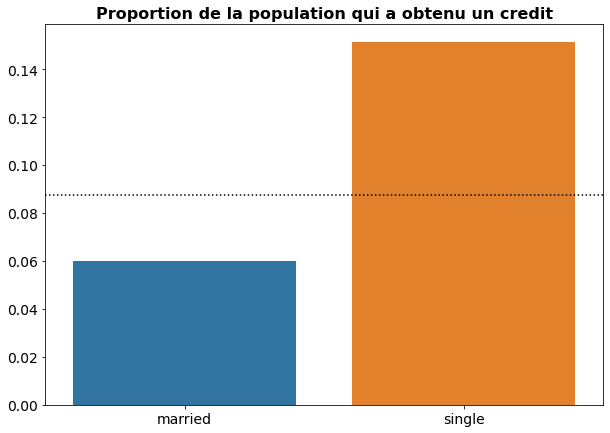

In [108]:
mean_get_loan = df['y'].mean()

fig, ax1 = plt.subplots(figsize=(10, 7))
sns.barplot(x=agg_marital.index, y=agg_marital.y, ax=ax1).\
set_title('Proportion de la population qui a obtenu un credit', fontsize=16, fontweight='bold')
ax1.axhline(mean_get_loan, color='k', linestyle=':')
ax1.set(xlabel='', ylabel='')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

Quelle est la valeur de ce seuil

In [109]:
print(mean_get_loan.round(3))

0.088


Expliquer briévement la signification de ce seuil

==> Les celibataires ont une probabilité supérieure à la moyenne d'obtenir un credit, tandis que les marriés ont une probabilité inférieure à la moyenne d'obtenir un credit.

# Introduction de la librairie AIF360

Conversion du dataset au format aif360: 
- Faite du OnhotEncoding sur les variables categorielle
- job,education,default,housing,loan, marital

In [110]:
df.head(10)

,age,job,education,marital,default,balance,housing,loan,previous,y
0,58,management,tertiary,married,no,2143,yes,no,0,0
1,44,technician,secondary,married,no,29,yes,no,0,0
2,33,entrepreneur,secondary,married,no,2,yes,yes,0,0
3,47,blue-collar,unknown,single,no,1506,yes,no,0,0
4,33,unknown,unknown,single,no,1,no,no,0,0
5,35,management,tertiary,married,no,231,yes,no,0,0
6,28,management,tertiary,married,no,447,yes,yes,0,0
7,42,entrepreneur,tertiary,single,yes,2,yes,no,0,0
8,58,retired,primary,single,no,121,yes,no,0,0
9,43,technician,secondary,married,no,593,yes,no,0,0


In [111]:
var_numerique = ["age","balance","previous", "y"]
var_categorielle = ["job","education","default","housing","loan", "marital"]

In [112]:

df_onehot = pd.concat([df[var_numerique], pd.get_dummies(df[var_categorielle])], axis=1)


In [113]:
df_onehot.head(5)

,age,balance,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,marital_married,marital_single
0,58,2143,0,0,0,0,0,0,1,0,...,1,0,1,0,0,1,1,0,1,0
1,44,29,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,1,0
2,33,2,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,1,0
3,47,1506,0,0,0,1,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
4,33,1,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1


- On va considérer une labelisation binaire (soit le statut est celibataire, soit marié).
- Nous convertissons donc les données en un BinaryLabelDataset, 
- Nous allos garder seulement l'attribut marital_married, donc nous supprimons la colonne marital_single car elle présente entre autre des informations redondantes.

In [115]:
df_aif = BinaryLabelDataset(df=df_onehot.drop('marital_single', axis=1), \
                            label_names=['y'], protected_attribute_names=['marital_married'])
print(df_aif)

               instance weights features                              \
                                                                       
                                     age balance previous job_admin.   
instance names                                                         
0                           1.0     58.0  2143.0      0.0        0.0   
1                           1.0     44.0    29.0      0.0        0.0   
2                           1.0     33.0     2.0      0.0        0.0   
3                           1.0     47.0  1506.0      0.0        0.0   
4                           1.0     33.0     1.0      0.0        0.0   
...                         ...      ...     ...      ...        ...   
45206                       1.0     51.0   825.0      0.0        0.0   
45207                       1.0     71.0  1729.0      0.0        0.0   
45208                       1.0     72.0  5715.0      3.0        0.0   
45209                       1.0     57.0   668.0      0.0       

Definir les préviléges des groupes (0/1) de la colonne marital_married

In [116]:
privileged_group = [{'marital_married': 0}]
unprivileged_group = [{'marital_married': 1}]

Diviser le dataset on a un ensemble de test, de train et de validation 

In [117]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(22605, 26), (13563, 26), (9043, 26)]


On va maintenant choisir une fairness metric et l'appliquer sur l'ensemble du dataset

Cette metrique fait référence aux diverses tentatives de correction des biais algorithmiques dans les processus de décision automatisés basés sur des modèles d'apprentissage automatique.

Il existe différentes mesures de fairness dans aif360, mais celle sur laquelle nous nous concentrerons est la disparate ipact (DI). Il s'agit de la probabilité de succès étant donné que le demandeur d'emploi est non privilégié (femme),divisée par la probabilité de succès étant donné que le demandeur d'emploi est privilégié (homme). Nous reformulons cela en 1 - min(DI, 1/DI), puisque DI peut être supérieur à 1, ce qui signifierait que le groupe privilégié est désavantagé. Pour notre indice de référence d'équité, nous exigeons que 1 - min(DI, 1/DI) < 0,2.

In [118]:
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)


def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)


print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.594


Cette valeur de 1 - min(DI, 1/DI) confirme que l'ensemble de données d'origine est biaisé. Si la valeur est de 0. Donc il n y a pas de biais. Ce n'est pas le cas ici

# Entrainner un modéle et mesurer le biais

- Choisir un logitique regression comme classifieur

In [119]:
def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale

In [120]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)

- Notre objectif maintenant c'est de: 
    + Trouver la meilleur modélisation qui donne la meilleur accuracy (noter bien le seil associé et l'accuracy)
    + Calculer au fur et à mesure le biais

In [122]:
thresh_arr = np.linspace(0.01, 0.5, 100)


def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob


y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)


def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())


def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:, 1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind': thresh_arr_best_ind, \
                                'thresh_arr_best': thresh_arr_best, \
                                'best_bal_acc': best_bal_acc, \
                                'disp_imp_at_best_bal_acc': disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
    get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))




100%|██████████| 100/100 [00:03<00:00, 33.23it/s]

Threshold corresponding to best balanced accuracy: 0.099
Best balanced accuracy: 0.628


In [123]:
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

1-min(DI, 1/DI): 1.0


divide by zero encountered in double_scalars


Expliquer le résultat obtenu

==> Cela montre que le seuil avec la meilleure précision est de 0,094. À ce seuil, notre métrique de précision (précision équilibrée) est de 0,753, mais notre métrique d'équité (1-min(DI, 1/DI)) est de 0,522, ce qui indique un biais. Nous pouvons tracer ces mesures de précision et d'équité sur une plage de seuils de classification :

+ On remarque aussi que meme avec la determination du meilleur seuil statistique et meilleur accuracy, il y a un biais. (calculé par le disparate impact)

- Dessiner les courbes suivantes:
    - Accuracy * Seuil
    - DI * Seuil

divide by zero encountered in true_divide


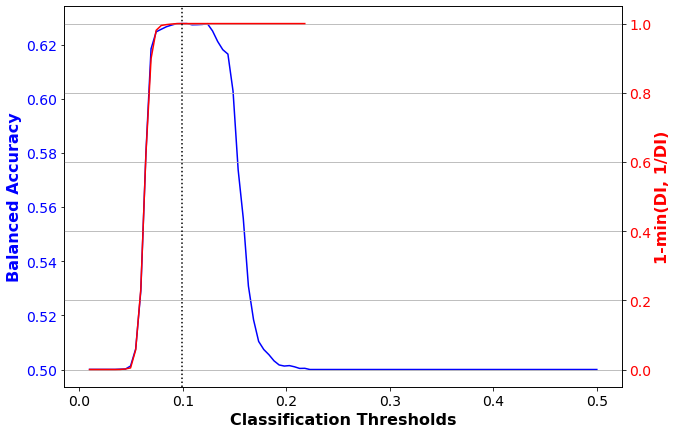

In [125]:

def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)


plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
                     '1-min(DI, 1/DI)', bal_acc_arr_orig, \
                     acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

Interpreter la signification des deux courbes

On vois sur la courbe que la meilleur accuracy trouvé est le pique en bleu, qui corresponde au seuil (Threshol associé de 0.084)
Dans la courbe rouge, on vois si on réequilibre à 0.084, le biais sera de 0.522, ce qui est un biais énorme


Completer alors les valeurs de nos 3 metriques : Accuracy, seuil, DI sur le jeu de test

In [126]:
y_test_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_tst)


def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:, 1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred


dataset_pred_labels_orig, classified_metric_orig, metric_pred_orig = test_lr_model( \
    y_data_pred_prob=y_test_pred_prob_orig, dataset=df_orig_tst, \
    thresh_arr=acc_metrics_orig.loc['thresh_arr_best', 0])

print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_orig).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_orig.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.099
Best balanced accuracy: 0.616
1-min(DI, 1/DI): 1.0


Expliquer les résultats

==> Comme pour l'ensemble de données de validation, nous nous retrouvons avec une bonne précision, mais une mauvaise métrique de Fairness. Cela montre que si nous ne considérons que la précision (comme c'est souvent le cas dans de nombreuses organisations), nous nous retrouvons avec un modèle biasé.

# Calibrage des données

Pour Traiter le biais, On va dans un premier temps transformer notre jeu de donnée par la technique "Reweighing". Cela attribue des pondérations différentes aux différentes entités de la population pour garantir le fairness.

In [127]:
RW = Reweighing(unprivileged_group, privileged_group)
df_transf_trn = RW.fit_transform(df_orig_trn)

# Calcul du fairness metric sur la dataset transformé

In [128]:
metric_transf_trn = BinaryLabelDatasetMetric(df_transf_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_transf_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.0


Que remarquez-vous ?

==> Lorsque nous calculons la métrique d'équité sur l'ensemble de données transformé, nous constatons qu'il est équitable.

# Entrainer un modéle sur le dataset non-biaisé (équilibré)

Refaire un autre modéle sur le jeu de donnée transformé, et on noter l'ensemble des metriques. Utiliser le jeu de données de validation dans ce cas

In [129]:
lr_transf, lr_scale_transf = train_lr_model(df_transf_trn)

In [130]:
y_validate_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_val)
acc_metrics_transf, bal_acc_arr_transf, disp_imp_arr_transf, dataset_pred_labels_transf = \
    get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_transf, dataset=df_orig_val)

print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_transf.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_transf.loc['disp_imp_at_best_bal_acc', 0]).round(3))


 25%|██▌       | 25/100 [00:00<00:01, 40.79it/s]divide by zero encountered in double_scalars
invalid value encountered in double_scalars
100%|██████████| 100/100 [00:03<00:00, 33.27it/s]

Threshold corresponding to best balanced accuracy: 0.104
Best balanced accuracy: 0.511
1-min(DI, 1/DI): 0.005


Expliquer le résultat

==> Cela montre que le seuil avec la meilleure précision est de 0,079. À ce seuil, notre métrique de précision (précision équilibrée) est de 0,749, et notre métrique d'équité (1-min(DI, 1/DI)) est de 0,107, ce qui n'indique aucun biais. 

Tracer l'ensemble de mesures précision et DI sur une plage de seuils de classification

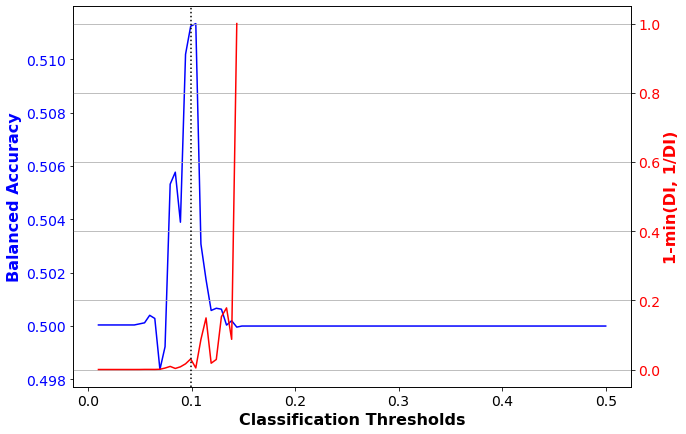

In [131]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_transf)), \
  '1-min(DI, 1/DI)', bal_acc_arr_transf, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))

Interpreter la courbe

- On vois sur la courbe que la meilleur accuracy trouvé est le pique en bleu 0.749, qui corresponde au seuil (Threshol associé de 0.079)
- Dans la courbe rouge, on vois si on réequilibre à ce seuil 0.089, le biais sera de 0.107, ce qui est un biais acceptable

# Tester le model sur le dataset non-biaisé (equilibré)

Noter l'ensemble des mesures obtenues

In [132]:
y_test_pred_prob_transf = get_y_pred_prob_lr(scale=lr_scale_transf, model=lr_transf, dataset=df_orig_tst)

dataset_pred_labels_transf, classified_metric_transf, metric_pred_transf = test_lr_model(\
  y_data_pred_prob=y_test_pred_prob_transf, dataset=df_orig_tst,\
  thresh_arr=acc_metrics_transf.loc['thresh_arr_best', 0])

print('Threshold corresponding to best balanced accuracy:', acc_metrics_transf.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', get_bal_acc(classified_metric_transf).round(3))
print('1-min(DI, 1/DI):', get_disparity_index(metric_pred_transf.disparate_impact()).round(3))

Threshold corresponding to best balanced accuracy: 0.104
Best balanced accuracy: 0.499
1-min(DI, 1/DI): 0.051


Interpreter le résultat

Comme pour l'ensemble de données de validation, nous nous retrouvons avec une bonne métrique de précision et de fairness. L'atténuation du biais a entraîné une légère détérioration de la précision (de 0,748 à 0,749), mais une amélioration considérable de l'équité (0,511 à 0,107). Cela montre que des modèles à la fois précis et justes peuvent être construits sur des données biaisées, à condition que l'atténuation des biais soit appliquée de manière appropriée.

# Conclusion

Nous avons vu ici comment un ensemble de données avec un biais historique entraînera des modèles construits dessus pour produire des résultats injustes. Dans notre scénario, plus de ressources seraient allouées aux celibataires, car ils ont toujours été plus susceptibles d'obtenir un credit. En effet, les techniques d'apprentissage automatique traditionnelles optimisent uniquement la précision, pas l'équité.Nous avons également vu qu'en appliquant des techniques simples d'atténuation des biais, nous pouvons supprimer le biais de l'ensemble de données et ainsi créer des modèles avec une précision comparable, mais des mesures d'équité bien meilleures. Ces techniques de détection et d'atténuation des biais sont très pertinentes pour toute organisation cherchant à automatiser la prise de décision sur les populations aux attributs protégés.